In [1]:
from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [2]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool, ChebConv, GlobalSumPool
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 1000  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 3  # Batch size


################################################################################
# LOAD DATA
################################################################################
import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')
from spektral.layers import GCNConv, GraphSageConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler


x_data = []
y_data = []

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
#         circs = ['c6288','c5315','c432', 'c499', 'c17', 'c880', 'c1355', 'c1908', 'c3540', 'adder.bench', 'arbiter.bench', 'cavlc.bench', 'dec.bench', 'voter.bench', "sin.bench","priority.bench", "multiplier.bench", "max.bench"]
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","dec.bench","int2float.bench","max.bench","multiplier.bench","priority.bench","sin.bench","voter.bench"]
#         circs = ["log2.bench"]
#         circs = ['adder.bench', "arbiter.bench",  "sin.bench", "multiplier.bench", "voter.bench", "priority.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, '../data/output', normalize="")
#             if sum(labels) >= 500:
            print(f"{circ}: {sum(labels)}, {len(labels)}")
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X.toarray())
            circuits.append(Graph(x=X, a=A, y=labels))

        return circuits

# def normalize_feature(circ_dataset):
#     scaler = MinMaxScaler()
#     scaler.fit(x_data)
#     for graph in circ_dataset:
#         graph.x = scaler.transform(graph.x)
#     return circ_dataset

dataset = CircuitDataset(transforms=[LayerPreprocess(ChebConv)])

# Parameters

F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
# dataset_tr = dataset[[ 0,7, 8,  14,  3, 13, 10, 15, 11,  2,  9, 17,  4, 12]]
# dataset_va = dataset[[1, 6]]
# dataset_te = dataset[[16, 5]]
# dataset_tr = dataset[[0,1]]
# dataset_va = dataset[[2, 3]]
# dataset_te = dataset[[4, 5]]

# loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
# loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
# loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(936, 936)
(936, 4)
dec.bench: [186.], 936
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
[ 0  1  8  5  3 13 16 15 11  2  9 17  4 12] [ 7 10] [14  6]


In [4]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

234966

In [5]:
from sklearn.utils.class_weight import compute_class_weight

y_data = []
for data_tr in dataset_tr:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))


def _compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y).astype('float32')
    class_weight = compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

weights = _compute_class_weight_dictionary(np.vstack((y_data)).reshape((-1,)))
print(weights)

{0.0: 0.559920411181657, 1.0: 4.672201009136779}


/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [6]:
%load_ext tensorboard

In [7]:
# from focal_loss import BinaryFocalLoss
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy

# focal_loss_fn = BinaryFocalLoss(gamma=0.9999, pos_weight=1)

In [8]:
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras import activations
from tensorflow.keras import layers
import tempfile

channels = 256         # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-3    # Learning rate
epochs = 500            # Number of training epochs
es_patience = 10    
patience = 100 # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
mask_in = Input((None, ))

# x_1 = BatchNormalization()(X_in)
# dropout_1 = Dropout(dropout)(x_1)
use_bias = True
x = GraphSageConv(256, K=25,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv1")([X_in, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = GraphSageConv(256, K=25,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv2")([X_in, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = ChebConv(128, K=1,
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv3")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = ChebConv(64, K=1,
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv4")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(256, K=25,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv5")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = ChebConv(8, K=2,
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv6")([x, fltr_in])

# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = ChebConv(4, K=2,
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv7")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(n_out, activation='sigmoid',
                         n_input_channels=dataset.n_node_features, name="conv8", use_bias=use_bias)([x, fltr_in])

model = Model(inputs=[X_in, fltr_in, mask_in], outputs=x)
optimizer = Adam(lr=learning_rate)

def masked_loss_and_accuracy(target, predictions):
    loss = binary_crossentropy(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

    return (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

tfcallback_dir = tempfile.TemporaryDirectory(suffix='tf', prefix='/tmp/', dir=None)

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir=tfcallback_dir,
        histogram_freq=1
)
# 
callback_GCN = [tbCallBack_GCN, EarlyStopping(patience=patience, restore_best_weights=True)]

X_in:  (None, 4)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
conv2 (GraphSageConv)           (None, 256)          2304        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        conv2[0][0] 

In [9]:
channels = 256  # Number of channels for GCN layers
dropout = 0.5  # Dropout rate for the features
learning_rate = 1e-3  # Learning rate
epochs = 200 

x_in = Input(shape=(F,))
a_in = Input((None,), sparse=True)
mask_in = Input((None, ))

x_1 = GCNConv(channels, activation="relu")([x_in, a_in])
x_1 = BatchNormalization()(x_1)
x_1 = Dropout(dropout)(x_1)
x_2 = GCNConv(channels, activation="relu")([x_1, a_in])
x_2 = BatchNormalization()(x_2)
x_2 = Dropout(dropout)(x_2)
fc2 = GCNConv(n_out, activation="sigmoid")([x_2, a_in])  


model = Model(inputs=[x_in, a_in, mask_in], outputs=fc2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

tfcallback_dir = tempfile.TemporaryDirectory(suffix='tf', prefix='/tmp/', dir=None).name
tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir=tfcallback_dir,
        histogram_freq=1
)
callback_GCN = [tbCallBack_GCN]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 256)          1280        input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 256)          1024        gcn_conv[0][0]             

In [10]:
epochs = 120
loader_tr, loader_va, loader_te = load_tr_data(epochs)
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    class_weight=weights,
    callbacks=callback_GCN
)

Epoch 1/120
5/5 [==============================] - 4s 499ms/step - loss: 0.9892 - acc: 0.4315 - precision_1: 0.4226 - recall_1: 0.4019 - val_loss: 0.7087 - val_acc: 0.1863 - val_precision_1: 0.1284 - val_recall_1: 0.9738
Epoch 2/120
5/5 [==============================] - 2s 339ms/step - loss: 0.6873 - acc: 0.6839 - precision_1: 0.6480 - recall_1: 0.8171 - val_loss: 0.6914 - val_acc: 0.6219 - val_precision_1: 0.2431 - val_recall_1: 0.9858
Epoch 3/120
5/5 [==============================] - 2s 463ms/step - loss: 0.6949 - acc: 0.7298 - precision_1: 0.6833 - recall_1: 0.8851 - val_loss: 0.6516 - val_acc: 0.8374 - val_precision_1: 0.1013 - val_recall_1: 0.0414
Epoch 4/120
5/5 [==============================] - 2s 436ms/step - loss: 0.5605 - acc: 0.7668 - precision_1: 0.7144 - recall_1: 0.8918 - val_loss: 0.6144 - val_acc: 0.8595 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/120
5/5 [==============================] - 2s 523ms/step - loss: 0.5936 - acc: 0.7462 - precision_1:

Epoch 37/120
5/5 [==============================] - 2s 449ms/step - loss: 0.4143 - acc: 0.8146 - precision_1: 0.8142 - recall_1: 0.8104 - val_loss: 0.3951 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 38/120
5/5 [==============================] - 3s 391ms/step - loss: 0.3514 - acc: 0.8663 - precision_1: 0.8468 - recall_1: 0.8938 - val_loss: 0.3890 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 39/120
5/5 [==============================] - 3s 682ms/step - loss: 0.4402 - acc: 0.8051 - precision_1: 0.7929 - recall_1: 0.8306 - val_loss: 0.3838 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 40/120
5/5 [==============================] - 2s 453ms/step - loss: 0.3728 - acc: 0.8545 - precision_1: 0.8554 - recall_1: 0.8522 - val_loss: 0.3755 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 41/120
5/5 [==============================] - 3s 375ms/step - loss: 0.3466

Epoch 73/120
5/5 [==============================] - 2s 561ms/step - loss: 0.3745 - acc: 0.8537 - precision_1: 0.8673 - recall_1: 0.8479 - val_loss: 0.3154 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 74/120
5/5 [==============================] - 3s 644ms/step - loss: 0.3357 - acc: 0.8708 - precision_1: 0.8615 - recall_1: 0.8934 - val_loss: 0.3058 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 75/120
5/5 [==============================] - 2s 547ms/step - loss: 0.3868 - acc: 0.8461 - precision_1: 0.8574 - recall_1: 0.8520 - val_loss: 0.3125 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 76/120
5/5 [==============================] - 2s 420ms/step - loss: 0.3553 - acc: 0.8618 - precision_1: 0.8919 - recall_1: 0.8216 - val_loss: 0.3192 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 77/120
5/5 [==============================] - 2s 497ms/step - loss: 0.3616

Epoch 109/120
5/5 [==============================] - 2s 321ms/step - loss: 0.2971 - acc: 0.8966 - precision_1: 0.8843 - recall_1: 0.9101 - val_loss: 0.2826 - val_acc: 0.8769 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 110/120
5/5 [==============================] - 2s 351ms/step - loss: 0.2832 - acc: 0.9021 - precision_1: 0.9061 - recall_1: 0.8971 - val_loss: 0.2829 - val_acc: 0.8758 - val_precision_1: 0.0714 - val_recall_1: 0.0011
Epoch 111/120
5/5 [==============================] - 2s 517ms/step - loss: 0.3272 - acc: 0.8706 - precision_1: 0.8747 - recall_1: 0.8710 - val_loss: 0.3003 - val_acc: 0.8758 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 112/120
5/5 [==============================] - 2s 520ms/step - loss: 0.4295 - acc: 0.8163 - precision_1: 0.8802 - recall_1: 0.7568 - val_loss: 0.3075 - val_acc: 0.8742 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 113/120
5/5 [==============================] - 2s 468ms/step - loss: 0.2802 - 

In [33]:
%tensorboard --logdir {tfcallback_dir}

Reusing TensorBoard on port 6007 (pid 59749), started 0:01:37 ago. (Use '!kill 59749' to kill it.)

In [34]:
model_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(model_loss))

1/1 [==============================] - 0s 460ms/step - loss: 0.3017 - acc: 0.8385 - precision_1: 0.3033 - recall_1: 0.4346
Done. Test loss: [0.30170050263404846, 0.8384600281715393, 0.3033313453197479, 0.4346104562282562]


In [35]:
from sklearn.metrics import classification_report
print(len(dataset_te))
for test_data in dataset_te:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

2
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.84      0.92       449
         1.0       0.42      1.00      0.59        50

    accuracy                           0.86       499
   macro avg       0.71      0.92      0.75       499
weighted avg       0.94      0.86      0.88       499

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     80649
         1.0       0.30      0.43      0.36      9294

    accuracy                           0.84     89943
   macro avg       0.62      0.66      0.63     89943
weighted avg       0.87      0.84      0.85     89943



In [36]:
from sklearn.metrics import classification_report
print(len(dataset_va))
for test_data in dataset_va:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

2
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      4716
         1.0       0.62      0.10      0.17       599

    accuracy                           0.89      5315
   macro avg       0.76      0.55      0.56      5315
weighted avg       0.87      0.89      0.86      5315

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      1846
         1.0       0.06      0.02      0.03       318

    accuracy                           0.80      2164
   macro avg       0.45      0.48      0.46      2164
weighted avg       0.73      0.80      0.77      2164



In [37]:
from sklearn.metrics import classification_report
print(len(dataset_tr))
for test_data in dataset_tr:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

14
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     15048
         1.0       1.00      0.33      0.50      1723

    accuracy                           0.93     16771
   macro avg       0.96      0.67      0.73     16771
weighted avg       0.94      0.93      0.92     16771

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     45110
         1.0       0.52      0.87      0.65      5012

    accuracy                           0.91     50122
   macro avg       0.75      0.89      0.80     50122
weighted avg       0.94      0.91      0.92     50122

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.63      0.72       750
         1.0       0.27      0.56      0.36       186

    accuracy                           0.61       936
   macro avg       0.56      0.59     

In [41]:
df = pd.DataFrame(np.vstack(np.array([gr.x for gr in dataset_tr])), columns=['level', 'c0', 'c1', 'ob'])

/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [42]:
df['y'] = y_data

level

c0

c1

ob



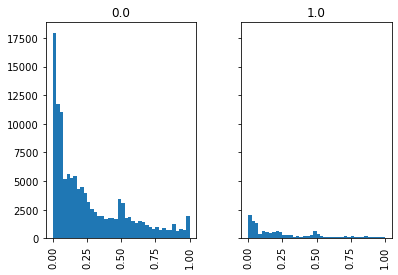

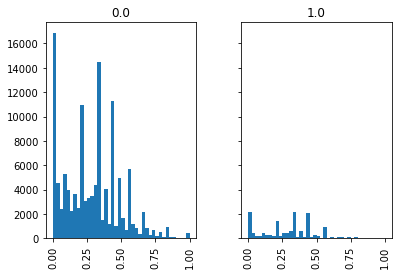

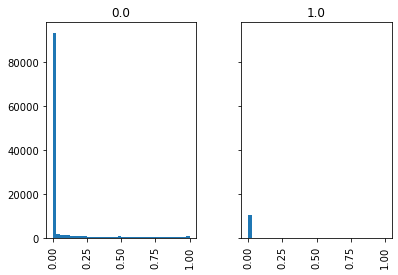

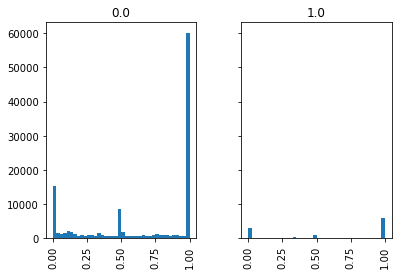

In [43]:
for col in ['level', 'c0', 'c1', 'ob']:
    print(col)
    df.hist(by='y', column=col, bins=40, sharex=True, sharey=True)
    print('')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffcf97dc898>,
      dtype=object)

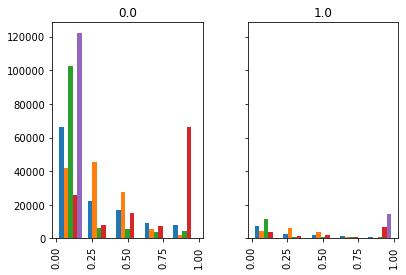

In [44]:
df.hist(by='y', bins=5, sharex=True, sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffcfa311c88>,
      dtype=object)

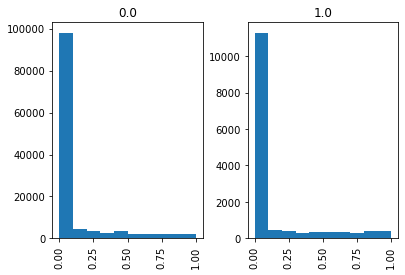

In [45]:
df.hist(by='y', column='c1')

In [46]:
df_te = pd.DataFrame(np.vstack(np.array([gr.x for gr in dataset_te])), columns=['level', 'c0', 'c1', 'ob'])
df_te['y'] = np.vstack(np.array([gr.y for gr in dataset_te]))
                       

/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


level

c0

c1

ob



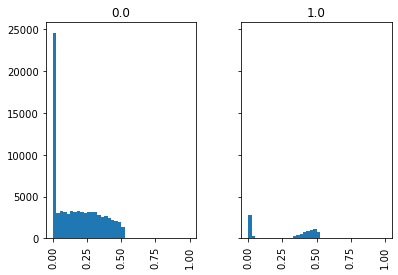

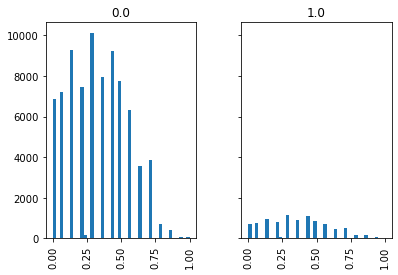

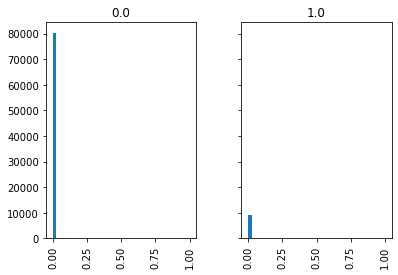

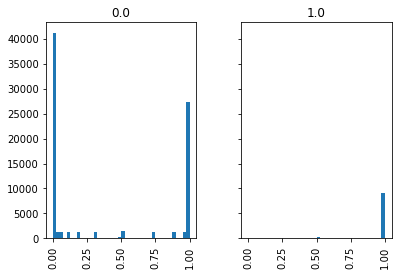

In [47]:
for col in ['level', 'c0', 'c1', 'ob']:
    print(col)
    df_te.hist(by='y', column=col, bins=40, sharex=True, sharey=True)
    print('')

In [48]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [50]:
import numpy as np
from sklearn.manifold import TSNE
df_1000 = stratified_sample_df(df, 'y', 1000)
X_embedded = TSNE(n_components=2).fit_transform(df_1000[:-1])
X_embedded.shape

(1999, 2)

level

c0

c1

ob



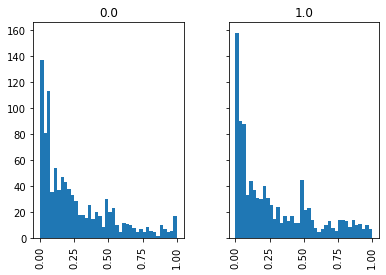

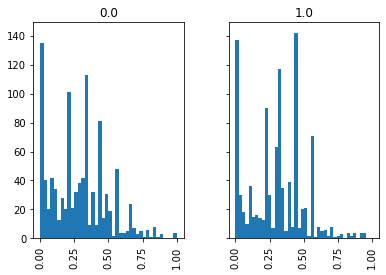

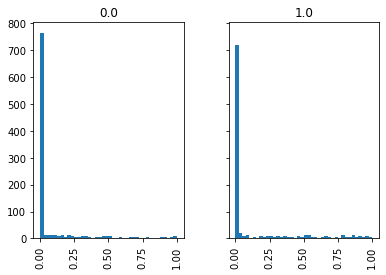

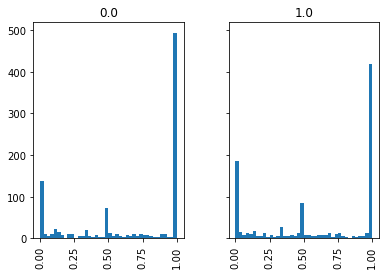

In [51]:
for col in ['level', 'c0', 'c1', 'ob']:
    print(col)
    df_1000.hist(by='y', column=col, bins=40, sharex=True, sharey=True)
    print('')

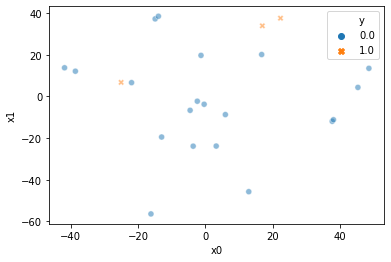

In [52]:
import seaborn as sns
df_tsne = pd.DataFrame(X_embedded, columns=['x0', 'x1'])
df_tsne['y'] = df_1000['y']
sns.scatterplot(data=df_tsne, x="x0", y="x1", hue="y", style="y", alpha=0.5)

In [53]:
import numpy as np
from sklearn import metrics

test_data = dataset_te[0]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y
y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])

fpr, tpr, thresholds = metrics.roc_curve(y_te, y_pred)

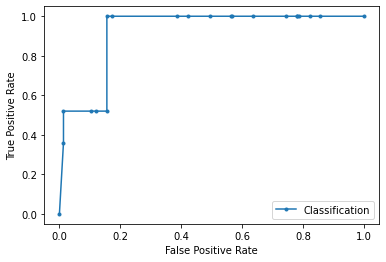

In [54]:
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot


# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Classification')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

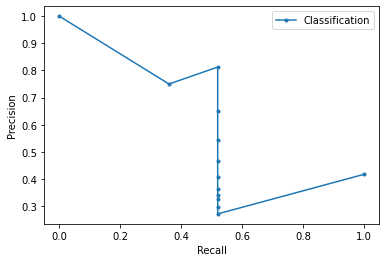

In [55]:
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_te, y_pred)

# cmap = plt.cm.get_cmap('hsv', len(thre))
pyplot.plot(recall, precision, marker='.', label='Classification')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [56]:
thres = thre.tolist() + [1]
n = len(thres)

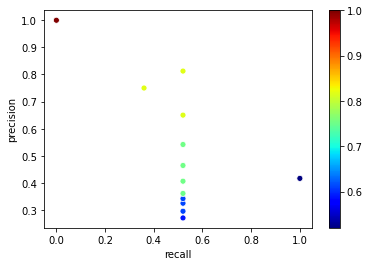

In [59]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot as plt


precision, recall, thre = precision_recall_curve(y_te, y_pred)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='jet')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

In [58]:
ds = CircuitDataset(transforms=[LayerPreprocess(ChebConv)])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
for g in ds:
    scaler = MinMaxScaler()
    scaler.fit(g.x)
    g.x = scaler.transform(g.x)

In [ ]:
df_all_data = pd.DataFrame(np.vstack(np.array([gr.x for gr in ds])), columns=['level', 'c0', 'c1', 'ob'])
df_all_data['y'] = np.vstack(np.array([gr.y for gr in ds]))

In [ ]:
for col in ['level', 'c0', 'c1', 'ob']:
    print(col)
    df_all_data.hist(by='y', column=col, bins=40, sharex=True, sharey=True)
    print('')

In [ ]:
ds1 = CircuitDataset(transforms=[LayerPreprocess(ChebConv)])

for g in ds1:
    scaler = MinMaxScaler()
    scaler.fit(g.x[0:1])
    g.x[0] = scaler.transform(g.x[0:1])
    
    

In [ ]:
# ds2 = CircuitDataset(transforms=[LayerPreprocess(ChebConv)])

for i, g in enumerate(ds2):
    print(f"----------------{i}-----------------")
    df_all_circ_data = pd.DataFrame(g.x, columns=['level', 'c0', 'c1', 'ob'])
    df_all_circ_data['y'] = g.y
    for col in ['level', 'c0', 'c1', 'ob']:
        df_all_circ_data.hist(by='y', column=col, sharex=True, sharey=True)
        plt.suptitle(col)
        plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler.fit_transform(ds1[0].x).shape

In [ ]:
ds1[0].x